<a href="https://colab.research.google.com/github/weathon/CHEM434/blob/main/ADSB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O adsb.jsonl file.weasoft.com/adsb.jsonl
!pip3 install basemap
!pip install basemap-data-hires
!pip install mapclassify
!pip3 install contextily

In [15]:
import contextily as cx

In [39]:
import json
from shapely.geometry import Point, LineString, shape, Polygon
data = []
with open("adsb.jsonl", "r") as f:
  for i in f.read().split("\n\n"):
    try:
      data.append(json.loads(i))
    except:
      pass

# with open("/content/adsb.jsonl.1", "r") as f:
#   for i in f.read().split("\n\n"):
#     try:
#       data.append(json.loads(i))
#     except:
#       pass

In [17]:
# last_ctime = 1e100 #NEED TO BE OUTSIDE
# index = 0
# for i in data:
#   if i["now"] - last_ctime > 20000:
#     print(index)
#   last_ctime = i["now"]
#   index+=1
# data = data[214:]

In [19]:
import pandas as pd
types = pd.read_csv("type.csv")
addition = {"B412":"Turboprop/Turboshaft", "DHC3": "Piston", "B212" : "Turboprop/Turboshaft", "R44":"Piston", "AS50":"Turboprop/Turboshaft"}
# pd.concat(types, pd.DataFrame.from_dict({"ICAO_Code": "B412", "Physical_Class_Engine": "Turboprop"}, ignore_index=True))
# pd.concat(types, pd.DataFrame.from_dict({"ICAO_Code": "DHC3", "Physical_Class_Engine": "Piston"}, ignore_index=True))
types["Physical_Class_Engine"] = types["Physical_Class_Engine"].apply(lambda x: x if x!= "Turboprop" else "Turboprop/Turboshaft")

In [20]:
def get_type(ICAO):
  ICAO = ICAO.strip()
  try:
    return types[types["ICAO_Code"]==ICAO]["Physical_Class_Engine"].item()
  except:
    try:
      return addition[ICAO]
    except:
      return ICAO

In [21]:
lats = []
lons = []
lab = []
alt = []
call_sign = []
for i in data:
  if "ac" not in i.keys():
    continue
  lats.extend(aircraft['lat'] for aircraft in i["ac"])
  lons.extend(aircraft['lon'] for aircraft in i["ac"])
  alt.extend(aircraft['alt_baro'] if "alt_baro" in aircraft.keys() else 0 for aircraft in i["ac"])
  lab.extend(aircraft['t'] if 't' in aircraft.keys() else "Unknown" for aircraft in i["ac"])
  call_sign.extend(aircraft['flight'] if 'flight' in aircraft.keys() else "Unknown" for aircraft in i["ac"])
  # lab.extend(aircraft['category'] if 'category' in aircraft.keys() else "0" for aircraft in i["ac"])

In [22]:
import pandas as pd
import geopandas
from shapely.geometry import LineString
df = pd.DataFrame({"time" :list(range(len(alt))), "call_sign":call_sign,  "lat" : lats, "lon":lons, "lab":lab,  "alt": [int(i) if i!= "ground" else 0 for i in alt]})#[legend.index(i) for i in lab]})
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat), crs="WGS84"
)

In [23]:
newdf = {"call_sign":[], "alt":[], "geo":[], "lab":[]}
for i in gdf["call_sign"].unique():
  flight = gdf[gdf["call_sign"]==i]
  flight = flight.sort_values("time")
  for j in range(1, len(flight.index)):
    flight.reset_index(drop=1, inplace=True)
    this = flight["alt"][j]
    last = flight["alt"][j-1]
    newdf["call_sign"].append(i)
    newdf["lab"].append(get_type(flight["lab"][0]))
    newdf["alt"].append((last + this)/2.0)
    newdf["geo"].append(LineString([flight["geometry"][j-1], flight["geometry"][j]]))
newdf = pd.DataFrame(newdf)

In [61]:
gdf = geopandas.GeoDataFrame(
    newdf[["lab", "alt","call_sign"]], geometry = newdf["geo"], crs="WGS84"
)

In [66]:
with open("UBCO", "r") as f:
  cors = f.read().split(" ")
cors = [i.split(",")[:2] for i in cors]
cors = cors[:-1]
UBCO = Polygon(cors)

In [67]:
UBCO = geopandas.GeoDataFrame({"index":[1], "Name":["UBCO"]}, geometry=[UBCO], crs="WGS84")

In [77]:
UBCO.to_crs(epsg=3857)

,index,Name,geometry
0,1,UBCO,"POLYGON ((-13291558.176 6435302.491, -13291474..."


(-13300000.0, -13275000.0, 6425000.0, 6460000.0)

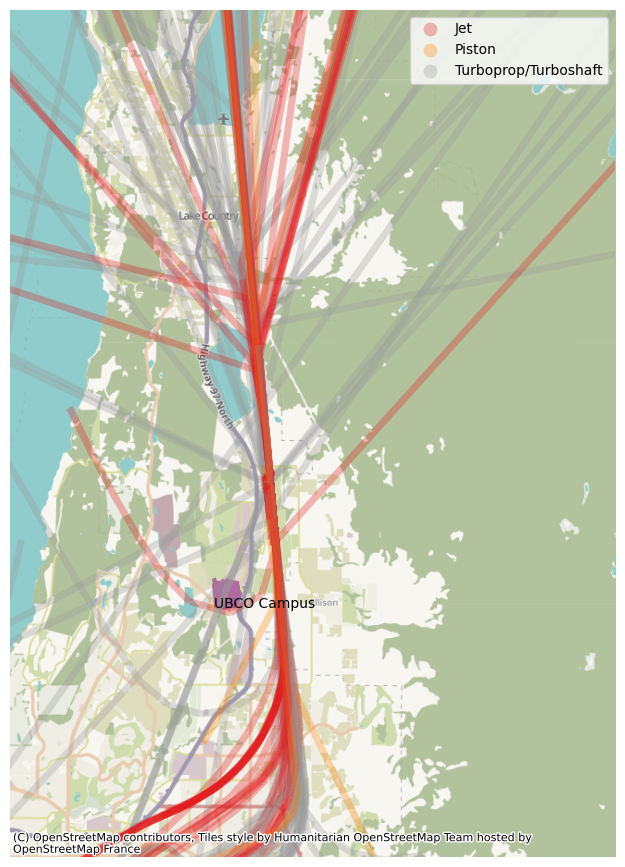

In [79]:
import pylab
pylab.rcParams["figure.figsize"] = (11, 11)
pylab.rcParams["font.family"] = "sans-serif"
gdf2 = gdf.to_crs(epsg=3857)
gdf2 = gdf2[gdf2["alt"]<6000]
# jets = gdf2[gdf2["lab"]=="Jet"]
# turbo = gdf2[gdf2["lab"]=="Turboprop/Turboshaft"]
# piston = gdf2[gdf2["lab"]=="Piston"]
# unknown = gdf2[gdf2["lab"]=="Unknown"]
# ax = gdf2.plot("alt", legend=True, linewidth=5, alpha=0.5)
ax = gdf2.plot("lab", legend=True, linewidth=5, alpha=0.3, cmap="Set1")
UBCO.to_crs(epsg=3857).plot(ax=ax, legend=True, alpha=0.5, label="UBCO Campus", color="purple")
ax.text(-13291558.176, 6435302.491, "UBCO Campus")
# ax = turbo.plot("lab", ax=ax, legend=True, linewidth=5, alpha=0.2, cmap="Set1")
# ax = jets.plot("lab", ax=ax, legend=True, linewidth=5, alpha=0.1, cmap="Set1")
# ax = unknown.plot("lab", ax=ax, legend=True, linewidth=5, alpha=0.5, cmap="Set1")
# https://gis.stackexchange.com/questions/375582/zoom-to-a-plot-with-geopandas-based-on-data-from-csv-and-shapefile
# minx, miny, maxx, maxy = gdf2.total_bounds
ax.set_xlim(-1.330e7, -1.3275e7)
ax.set_ylim(6.425e6, 6.46e6)
# pylab.title("Jets")
cx.add_basemap(ax)
pylab.axis("off")

In [26]:
j, p, t = len(gdf2[gdf2["lab"]=="Jet"]["call_sign"].unique()),len(gdf2[gdf2["lab"]=="Piston"]["call_sign"].unique()),len(gdf2[gdf2["lab"]=="Turboprop/Turboshaft"]["call_sign"].unique())

<BarContainer object of 1 artists>

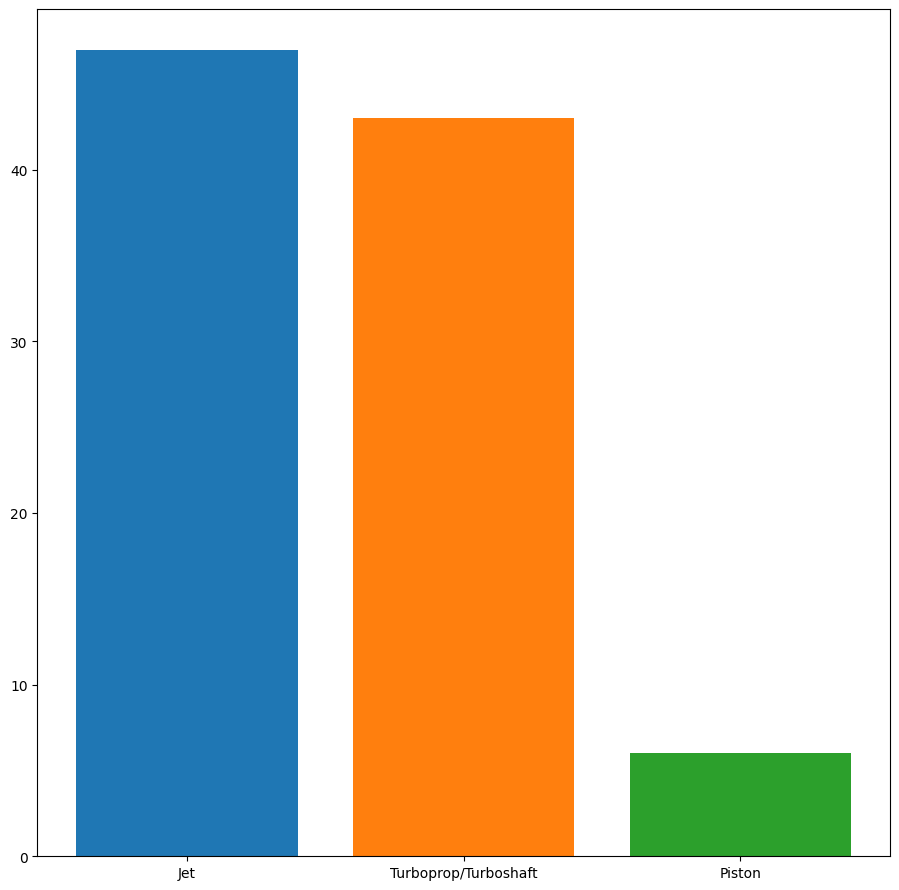

In [27]:
pylab.bar("Jet", j)
pylab.bar("Turboprop/Turboshaft", t)
pylab.bar("Piston", p)